In [ ]:
#!pip install pydot

In [ ]:
#!pip install graphviz 

In [1]:
import os
import pandas as pd

In [2]:

import matplotlib.pylab as plt
import numpy as np
import pandas as pd

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [5]:
os.listdir()

['.ipynb_checkpoints',
 '2.1_data_loader_PyTorch.ipynb',
 '4.1_resnet18_PyTorch.ipynb',
 '5.4softmax_in_one_dimension_v2.ipynb',
 '7.4one_layer_neural_network_MNIST.ipynb',
 'a0_m4_exercice3.2_spark2.3_python3.5_cos.ipynb.ipynb',
 'a6_w4_assignment_SudhishKumar.ipynb.ipynb',
 'Assignment_Submission_capstone_coursera_PyTorch.ipynb',
 'Deep_Learning_NN_Submission_PartD.ipynb',
 'LISH-MOA.ipynb',
 'ML0120EN-5.1-Review-Autoencoders.ipynb',
 'sample_submission.csv',
 'test_features.csv',
 'train_features.csv',
 'train_targets_nonscored.csv',
 'train_targets_scored.csv']

In [6]:
# Create class for plotting

def plot_data(data_set, model = None, n = 1, color = False):
    X = data_set[:][0]
    Y = data_set[:][1]
    plt.plot(X[Y == 0, 0].numpy(), Y[Y == 0].numpy(), 'bo', label = 'y = 0')
    plt.plot(X[Y == 1, 0].numpy(), 0 * Y[Y == 1].numpy(), 'ro', label = 'y = 1')
    plt.plot(X[Y == 2, 0].numpy(), 0 * Y[Y == 2].numpy(), 'go', label = 'y = 2')
    plt.ylim((-0.1, 3))
    plt.legend()
    if model != None:
        w = list(model.parameters())[0][0].detach()
        b = list(model.parameters())[1][0].detach()
        y_label = ['yhat=0', 'yhat=1', 'yhat=2']
        y_color = ['b', 'r', 'g']
        Y = []
        for w, b, y_l, y_c in zip(model.state_dict()['0.weight'], model.state_dict()['0.bias'], y_label, y_color):
            Y.append((w * X + b).numpy())
            plt.plot(X.numpy(), (w * X + b).numpy(), y_c, label = y_l)
        if color == True:
            x = X.numpy()
            x = x.reshape(-1)
            top = np.ones(x.shape)
            y0 = Y[0].reshape(-1)
            y1 = Y[1].reshape(-1)
            y2 = Y[2].reshape(-1)
            plt.fill_between(x, y0, where = y1 > y1, interpolate = True, color = 'blue')
            plt.fill_between(x, y0, where = y1 > y2, interpolate = True, color = 'blue')
            plt.fill_between(x, y1, where = y1 > y0, interpolate = True, color = 'red')
            plt.fill_between(x, y1, where = ((y1 > y2) * (y1 > y0)),interpolate = True, color = 'red')
            plt.fill_between(x, y2, where = (y2 > y0) * (y0 > 0),interpolate = True, color = 'green')
            plt.fill_between(x, y2, where = (y2 > y1), interpolate = True, color = 'green')
    plt.legend()
    plt.show()

#Set the random seed
torch.manual_seed(0)

In [7]:
def plot_accuracy_loss(training_results): 
    plt.subplot(2, 1, 1)
    plt.plot(training_results['training_loss'], 'r')
    plt.ylabel('loss')
    plt.title('training loss iterations')
    plt.subplot(2, 1, 2)
    plt.plot(training_results['validation_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epochs')   
    plt.show()

In [8]:
def print_model_parameters(model):
    count = 0
    for ele in model.state_dict():
        count += 1
        if count % 2 != 0:
            print ("The following are the parameters for the layer ", count // 2 + 1)
        if ele.find("bias") != -1:
            print("The size of bias: ", model.state_dict()[ele].size())
        else:
            print("The size of weights: ", model.state_dict()[ele].size())

In [9]:

def show_data(data_sample):
    plt.imshow(data_sample.numpy().reshape(28, 28), cmap='gray')
    plt.show()

In [10]:

df_train=pd.read_csv('train_features.csv')

In [11]:
df_train.describe()

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,48.020156,0.248366,-0.095684,0.152253,0.081971,0.057347,-0.138836,0.035961,-0.202651,-0.190083,...,-0.469244,-0.461411,-0.513256,-0.500142,-0.507093,-0.353726,-0.463485,-0.378241,-0.470252,-0.301505
std,19.402807,1.393399,0.812363,1.035731,0.950012,1.032091,1.179388,0.882395,1.125494,1.749885,...,2.000488,2.042475,2.001714,2.107105,2.159589,1.629291,2.059725,1.703615,1.834828,1.407918
min,24.000000,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,24.000000,-0.473075,-0.562200,-0.437750,-0.429575,-0.470925,-0.602225,-0.493900,-0.525175,-0.511675,...,-0.566175,-0.565975,-0.589975,-0.568700,-0.563775,-0.567975,-0.552575,-0.561000,-0.592600,-0.562900
50%,48.000000,-0.008850,-0.046600,0.075200,0.008050,-0.026900,-0.015650,-0.000650,-0.017900,0.010000,...,-0.009900,0.003250,-0.009100,-0.013750,-0.003300,-0.010250,-0.001250,-0.006800,0.014000,-0.019500
75%,72.000000,0.525700,0.403075,0.663925,0.463400,0.465375,0.510425,0.528725,0.411900,0.549225,...,0.457750,0.461500,0.445675,0.452900,0.470900,0.444750,0.465225,0.446400,0.461275,0.438650
max,72.000000,10.000000,5.039000,8.257000,10.000000,10.000000,7.282000,7.333000,5.473000,8.887000,...,4.069000,3.960000,3.927000,3.596000,3.747000,2.814000,3.505000,2.924000,3.111000,3.805000


In [12]:
df_y_train=pd.read_csv('train_targets_scored.csv')

In [13]:
df_y_train.describe()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,0.000714,0.000756,0.001008,0.007979,0.012640,0.003065,0.002268,0.004031,0.000504,0.011338,...,0.000252,0.001050,0.002016,0.013270,0.003065,0.000252,0.007139,0.001092,0.001638,0.001260
std,0.026709,0.027483,0.031731,0.088967,0.111716,0.055283,0.047566,0.063365,0.022443,0.105876,...,0.015871,0.032384,0.044851,0.114429,0.055283,0.015871,0.084190,0.033025,0.040436,0.035472
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
df_train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [15]:
df_y_train.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Identify Columns that are categorical

In [16]:
num_cols = df_train._get_numeric_data().columns
cols=df_train.columns
list(set(cols) - set(num_cols))

['cp_type', 'sig_id', 'cp_dose']

## Create X and Y

### Join the dataframes by index to confirm X and Y match-up

In [17]:
df_merged = pd.merge(df_train, df_y_train, left_index=True, right_index=True)

In [18]:
df_merged.describe()

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,48.020156,0.248366,-0.095684,0.152253,0.081971,0.057347,-0.138836,0.035961,-0.202651,-0.190083,...,0.000252,0.001050,0.002016,0.013270,0.003065,0.000252,0.007139,0.001092,0.001638,0.001260
std,19.402807,1.393399,0.812363,1.035731,0.950012,1.032091,1.179388,0.882395,1.125494,1.749885,...,0.015871,0.032384,0.044851,0.114429,0.055283,0.015871,0.084190,0.033025,0.040436,0.035472
min,24.000000,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,-0.473075,-0.562200,-0.437750,-0.429575,-0.470925,-0.602225,-0.493900,-0.525175,-0.511675,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,48.000000,-0.008850,-0.046600,0.075200,0.008050,-0.026900,-0.015650,-0.000650,-0.017900,0.010000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,72.000000,0.525700,0.403075,0.663925,0.463400,0.465375,0.510425,0.528725,0.411900,0.549225,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,72.000000,10.000000,5.039000,8.257000,10.000000,10.000000,7.282000,7.333000,5.473000,8.887000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
X_columns=df_train.columns.tolist()
Y_columns=df_y_train.columns.tolist()
drop_list=['sig_id']
encoding_list=['cp_dose', 'cp_type']


In [20]:
X=df_merged[[x for x in X_columns if x not in drop_list]] # Extracting features
Y=df_merged[[y for y in Y_columns if y not in drop_list]] # Extracting outputs

In [21]:
X.describe()

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,48.020156,0.248366,-0.095684,0.152253,0.081971,0.057347,-0.138836,0.035961,-0.202651,-0.190083,...,-0.469244,-0.461411,-0.513256,-0.500142,-0.507093,-0.353726,-0.463485,-0.378241,-0.470252,-0.301505
std,19.402807,1.393399,0.812363,1.035731,0.950012,1.032091,1.179388,0.882395,1.125494,1.749885,...,2.000488,2.042475,2.001714,2.107105,2.159589,1.629291,2.059725,1.703615,1.834828,1.407918
min,24.000000,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,24.000000,-0.473075,-0.562200,-0.437750,-0.429575,-0.470925,-0.602225,-0.493900,-0.525175,-0.511675,...,-0.566175,-0.565975,-0.589975,-0.568700,-0.563775,-0.567975,-0.552575,-0.561000,-0.592600,-0.562900
50%,48.000000,-0.008850,-0.046600,0.075200,0.008050,-0.026900,-0.015650,-0.000650,-0.017900,0.010000,...,-0.009900,0.003250,-0.009100,-0.013750,-0.003300,-0.010250,-0.001250,-0.006800,0.014000,-0.019500
75%,72.000000,0.525700,0.403075,0.663925,0.463400,0.465375,0.510425,0.528725,0.411900,0.549225,...,0.457750,0.461500,0.445675,0.452900,0.470900,0.444750,0.465225,0.446400,0.461275,0.438650
max,72.000000,10.000000,5.039000,8.257000,10.000000,10.000000,7.282000,7.333000,5.473000,8.887000,...,4.069000,3.960000,3.927000,3.596000,3.747000,2.814000,3.505000,2.924000,3.111000,3.805000


In [22]:
X['cp_type']=pd.Categorical(X['cp_type'])
X['cp_dose']=pd.Categorical(X['cp_dose'])
X['cp_type_code'] = X['cp_type'].cat.codes
X['cp_dose_code'] = X['cp_dose'].cat.codes


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [23]:
X.columns

Index(['cp_type', 'cp_time', 'cp_dose', 'g-0', 'g-1', 'g-2', 'g-3', 'g-4',
       'g-5', 'g-6',
       ...
       'c-92', 'c-93', 'c-94', 'c-95', 'c-96', 'c-97', 'c-98', 'c-99',
       'cp_type_code', 'cp_dose_code'],
      dtype='object', length=877)

In [24]:
X.dtypes

cp_type         category
cp_time            int64
cp_dose         category
g-0              float64
g-1              float64
g-2              float64
g-3              float64
g-4              float64
g-5              float64
g-6              float64
g-7              float64
g-8              float64
g-9              float64
g-10             float64
g-11             float64
g-12             float64
g-13             float64
g-14             float64
g-15             float64
g-16             float64
g-17             float64
g-18             float64
g-19             float64
g-20             float64
g-21             float64
g-22             float64
g-23             float64
g-24             float64
g-25             float64
g-26             float64
                  ...   
c-72             float64
c-73             float64
c-74             float64
c-75             float64
c-76             float64
c-77             float64
c-78             float64
c-79             float64
c-80             float64


In [25]:
Y.dtypes

5-alpha_reductase_inhibitor                        int64
11-beta-hsd1_inhibitor                             int64
acat_inhibitor                                     int64
acetylcholine_receptor_agonist                     int64
acetylcholine_receptor_antagonist                  int64
acetylcholinesterase_inhibitor                     int64
adenosine_receptor_agonist                         int64
adenosine_receptor_antagonist                      int64
adenylyl_cyclase_activator                         int64
adrenergic_receptor_agonist                        int64
adrenergic_receptor_antagonist                     int64
akt_inhibitor                                      int64
aldehyde_dehydrogenase_inhibitor                   int64
alk_inhibitor                                      int64
ampk_activator                                     int64
analgesic                                          int64
androgen_receptor_agonist                          int64
androgen_receptor_antagonist   

In [26]:
X_data=X[[x for x in X.columns if x not in encoding_list]]

In [91]:
X_data.describe()

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,cp_type_code,cp_dose_code
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,48.020156,0.248366,-0.095684,0.152253,0.081971,0.057347,-0.138836,0.035961,-0.202651,-0.190083,...,-0.513256,-0.500142,-0.507093,-0.353726,-0.463485,-0.378241,-0.470252,-0.301505,0.921643,0.489922
std,19.402807,1.393399,0.812363,1.035731,0.950012,1.032091,1.179388,0.882395,1.125494,1.749885,...,2.001714,2.107105,2.159589,1.629291,2.059725,1.703615,1.834828,1.407918,0.268739,0.499909
min,24.000000,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,0.000000,0.000000
25%,24.000000,-0.473075,-0.562200,-0.437750,-0.429575,-0.470925,-0.602225,-0.493900,-0.525175,-0.511675,...,-0.589975,-0.568700,-0.563775,-0.567975,-0.552575,-0.561000,-0.592600,-0.562900,1.000000,0.000000
50%,48.000000,-0.008850,-0.046600,0.075200,0.008050,-0.026900,-0.015650,-0.000650,-0.017900,0.010000,...,-0.009100,-0.013750,-0.003300,-0.010250,-0.001250,-0.006800,0.014000,-0.019500,1.000000,0.000000
75%,72.000000,0.525700,0.403075,0.663925,0.463400,0.465375,0.510425,0.528725,0.411900,0.549225,...,0.445675,0.452900,0.470900,0.444750,0.465225,0.446400,0.461275,0.438650,1.000000,1.000000
max,72.000000,10.000000,5.039000,8.257000,10.000000,10.000000,7.282000,7.333000,5.473000,8.887000,...,3.927000,3.596000,3.747000,2.814000,3.505000,2.924000,3.111000,3.805000,1.000000,1.000000


In [94]:
for c in X_data.columns:
    print("Number of unique values for column {} in X_data = {}".format(c,len(np.unique(X_data[c]))))


Number of unique values for column cp_time in X_data = 3
Number of unique values for column g-0 in X_data = 14367
Number of unique values for column g-1 in X_data = 13893
Number of unique values for column g-2 in X_data = 14210
Number of unique values for column g-3 in X_data = 12793
Number of unique values for column g-4 in X_data = 14038
Number of unique values for column g-5 in X_data = 14375
Number of unique values for column g-6 in X_data = 13741
Number of unique values for column g-7 in X_data = 14106
Number of unique values for column g-8 in X_data = 14583
Number of unique values for column g-9 in X_data = 14081
Number of unique values for column g-10 in X_data = 14316
Number of unique values for column g-11 in X_data = 14385
Number of unique values for column g-12 in X_data = 14274
Number of unique values for column g-13 in X_data = 14186
Number of unique values for column g-14 in X_data = 14400
Number of unique values for column g-15 in X_data = 10757
Number of unique values f

Number of unique values for column g-148 in X_data = 14673
Number of unique values for column g-149 in X_data = 13977
Number of unique values for column g-150 in X_data = 13586
Number of unique values for column g-151 in X_data = 13876
Number of unique values for column g-152 in X_data = 14521
Number of unique values for column g-153 in X_data = 6927
Number of unique values for column g-154 in X_data = 14177
Number of unique values for column g-155 in X_data = 13466
Number of unique values for column g-156 in X_data = 14611
Number of unique values for column g-157 in X_data = 12530
Number of unique values for column g-158 in X_data = 14430
Number of unique values for column g-159 in X_data = 14032
Number of unique values for column g-160 in X_data = 14630
Number of unique values for column g-161 in X_data = 13871
Number of unique values for column g-162 in X_data = 14370
Number of unique values for column g-163 in X_data = 14396
Number of unique values for column g-164 in X_data = 1055

Number of unique values for column g-296 in X_data = 13605
Number of unique values for column g-297 in X_data = 14159
Number of unique values for column g-298 in X_data = 14576
Number of unique values for column g-299 in X_data = 14535
Number of unique values for column g-300 in X_data = 14834
Number of unique values for column g-301 in X_data = 12249
Number of unique values for column g-302 in X_data = 14072
Number of unique values for column g-303 in X_data = 12119
Number of unique values for column g-304 in X_data = 14334
Number of unique values for column g-305 in X_data = 14088
Number of unique values for column g-306 in X_data = 12562
Number of unique values for column g-307 in X_data = 3202
Number of unique values for column g-308 in X_data = 14307
Number of unique values for column g-309 in X_data = 14227
Number of unique values for column g-310 in X_data = 14131
Number of unique values for column g-311 in X_data = 14218
Number of unique values for column g-312 in X_data = 1380

Number of unique values for column g-438 in X_data = 14354
Number of unique values for column g-439 in X_data = 14348
Number of unique values for column g-440 in X_data = 14009
Number of unique values for column g-441 in X_data = 14456
Number of unique values for column g-442 in X_data = 14096
Number of unique values for column g-443 in X_data = 14338
Number of unique values for column g-444 in X_data = 13822
Number of unique values for column g-445 in X_data = 14077
Number of unique values for column g-446 in X_data = 12889
Number of unique values for column g-447 in X_data = 14099
Number of unique values for column g-448 in X_data = 13921
Number of unique values for column g-449 in X_data = 14505
Number of unique values for column g-450 in X_data = 14088
Number of unique values for column g-451 in X_data = 14431
Number of unique values for column g-452 in X_data = 13983
Number of unique values for column g-453 in X_data = 13916
Number of unique values for column g-454 in X_data = 134

Number of unique values for column g-577 in X_data = 14017
Number of unique values for column g-578 in X_data = 14106
Number of unique values for column g-579 in X_data = 14414
Number of unique values for column g-580 in X_data = 11933
Number of unique values for column g-581 in X_data = 13936
Number of unique values for column g-582 in X_data = 14222
Number of unique values for column g-583 in X_data = 12908
Number of unique values for column g-584 in X_data = 14150
Number of unique values for column g-585 in X_data = 14283
Number of unique values for column g-586 in X_data = 14093
Number of unique values for column g-587 in X_data = 14061
Number of unique values for column g-588 in X_data = 14212
Number of unique values for column g-589 in X_data = 13965
Number of unique values for column g-590 in X_data = 13708
Number of unique values for column g-591 in X_data = 14349
Number of unique values for column g-592 in X_data = 14254
Number of unique values for column g-593 in X_data = 137

Number of unique values for column g-741 in X_data = 13905
Number of unique values for column g-742 in X_data = 14154
Number of unique values for column g-743 in X_data = 14381
Number of unique values for column g-744 in X_data = 14294
Number of unique values for column g-745 in X_data = 14861
Number of unique values for column g-746 in X_data = 14549
Number of unique values for column g-747 in X_data = 13473
Number of unique values for column g-748 in X_data = 14336
Number of unique values for column g-749 in X_data = 13575
Number of unique values for column g-750 in X_data = 13563
Number of unique values for column g-751 in X_data = 13961
Number of unique values for column g-752 in X_data = 13992
Number of unique values for column g-753 in X_data = 14020
Number of unique values for column g-754 in X_data = 10203
Number of unique values for column g-755 in X_data = 14191
Number of unique values for column g-756 in X_data = 8028
Number of unique values for column g-757 in X_data = 1392

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026943BE66A0>,
      dtype=object)

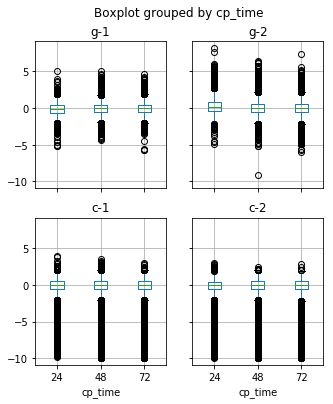

In [107]:
skip_list=['cp_type_code','cp_dose_code']
X_data.boxplot(['g-1','g-2','c-1','c-2'],'cp_time',figsize=(5,6))

In [28]:
inputCols=X_data.columns.tolist()

In [29]:
outputCols=Y.columns.tolist()

In [30]:
outputCols

['5-alpha_reductase_inhibitor',
 '11-beta-hsd1_inhibitor',
 'acat_inhibitor',
 'acetylcholine_receptor_agonist',
 'acetylcholine_receptor_antagonist',
 'acetylcholinesterase_inhibitor',
 'adenosine_receptor_agonist',
 'adenosine_receptor_antagonist',
 'adenylyl_cyclase_activator',
 'adrenergic_receptor_agonist',
 'adrenergic_receptor_antagonist',
 'akt_inhibitor',
 'aldehyde_dehydrogenase_inhibitor',
 'alk_inhibitor',
 'ampk_activator',
 'analgesic',
 'androgen_receptor_agonist',
 'androgen_receptor_antagonist',
 'anesthetic_-_local',
 'angiogenesis_inhibitor',
 'angiotensin_receptor_antagonist',
 'anti-inflammatory',
 'antiarrhythmic',
 'antibiotic',
 'anticonvulsant',
 'antifungal',
 'antihistamine',
 'antimalarial',
 'antioxidant',
 'antiprotozoal',
 'antiviral',
 'apoptosis_stimulant',
 'aromatase_inhibitor',
 'atm_kinase_inhibitor',
 'atp-sensitive_potassium_channel_antagonist',
 'atp_synthase_inhibitor',
 'atpase_inhibitor',
 'atr_kinase_inhibitor',
 'aurora_kinase_inhibitor',
 '

In [31]:
num_inputs=X_data.shape[1]
print("Number of inputs: {}".format(num_inputs))
inputs = keras.Input(shape=(num_inputs,))


Number of inputs: 875


In [32]:
inputs.dtype

tf.float32

In [ ]:
# define regression model
def regression_model(n_cols):
    # create model
    model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
    model = Sequential()
    # hidden layer of 10 nodes and 'relu' activation function.
    model.add(Dense(10, activation='relu', input_shape=(n_cols,)))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))   
    # output layer
    model.add(Dense(1))
    
    # compile model using 'adam' optimizer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

### Normalize X

In [33]:
X_norm = (X_data - X_data.mean()) / X_data.std()
X_norm.head()

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,cp_type_code,cp_dose_code
0,-1.237973,0.583920,0.804300,-0.386349,-0.739750,-0.243919,-0.740354,-1.198965,0.151090,0.425676,...,0.659863,0.499473,0.146275,0.621206,0.031745,0.347579,0.463451,0.510758,0.291574,-0.980022
1,1.235896,-0.124922,0.620885,0.141781,-0.022706,0.931752,0.559218,0.224547,0.479657,-0.122646,...,0.491607,0.248275,0.371734,0.517787,0.298916,0.294868,0.587495,0.737689,0.291574,-0.980022
2,-0.001039,0.272452,0.833843,1.353388,-0.166705,-0.086859,1.168263,0.153604,0.371527,0.112341,...,0.561297,0.247943,-0.378270,0.022295,-0.086524,0.093649,-0.511082,0.706437,0.291574,-0.980022
3,-0.001039,-0.546984,-0.188852,-0.403438,0.470340,3.880135,-0.568655,-2.260849,0.339275,0.033135,...,-2.556182,-0.416618,-0.164896,-0.573424,-0.561976,-0.293587,0.045046,-0.365003,0.291574,-0.980022
4,1.235896,-0.411775,-0.375714,0.789535,0.642022,1.318346,-0.581288,-0.358072,0.046958,-0.393635,...,0.589623,0.744691,0.490553,0.031072,0.278137,0.391369,0.049951,0.720216,0.291574,1.020342


In [34]:
number_of_epoch=50
split_amount=0.3
# Using Normalized data
X_train, X_test, y_train, y_test = train_test_split( X_norm, Y, test_size=split_amount, random_state=4)


In [35]:
X_train.shape

(16669, 875)

In [38]:
number_output=y_train.shape[1]
print("Number of outputs = {}".format(number_output))

Number of outputs = 206


In [60]:
dense = layers.Dense(200, activation="relu")
x = dense(inputs)
#x = layers.Dense(200, activation="relu")(x)
x = layers.Dense(100, activation="relu")(x)
#x = layers.Dense(200, activation="relu")(x)
x = layers.Dense(200, activation="relu")(x)
outputs = layers.Dense(number_output,activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="LISH-MOA")
model.summary()

Model: "LISH-MOA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 875)]             0         
_________________________________________________________________
dense_13 (Dense)             (None, 200)               175200    
_________________________________________________________________
dense_14 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_15 (Dense)             (None, 200)               20200     
_________________________________________________________________
dense_16 (Dense)             (None, 206)               41406     
Total params: 256,906
Trainable params: 256,906
Non-trainable params: 0
_________________________________________________________________


In [61]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

In [62]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer)


In [63]:
history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_split=0.0)

Epoch 1/50
261/261 [==============================] - 1s 4ms/step - loss: 1532.0582
Epoch 2/50
261/261 [==============================] - 1s 4ms/step - loss: 3.6783
Epoch 3/50
261/261 [==============================] - 1s 4ms/step - loss: 3.5793
Epoch 4/50
261/261 [==============================] - 1s 4ms/step - loss: 3.5009
Epoch 5/50
261/261 [==============================] - 1s 4ms/step - loss: 3.4452
Epoch 6/50
261/261 [==============================] - 1s 4ms/step - loss: 10.8848
Epoch 7/50
261/261 [==============================] - 1s 4ms/step - loss: 47.6515
Epoch 8/50
261/261 [==============================] - 1s 4ms/step - loss: 608.4786
Epoch 9/50
261/261 [==============================] - 1s 4ms/step - loss: 3.5933
Epoch 10/50
261/261 [==============================] - 1s 4ms/step - loss: 3.5644
Epoch 11/50
261/261 [==============================] - 1s 4ms/step - loss: 3.5391
Epoch 12/50
261/261 [==============================] - 1s 4ms/step - loss: 3.5186
Epoch 13/50
261/26

In [71]:
y_prob = model.predict(X_test) 
y_model_test = y_prob.argmax()



In [75]:
y_prob.shape

(7145, 206)

In [82]:
y_model_test=np.eye(206,dtype=int)[np.argmax(y_prob,axis=1)]

In [84]:
y_model_test.shape

(7145, 206)

In [85]:
y_model_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [86]:
y_model_test_output=pd.DataFrame(data=y_model_test, index=y_test.index, columns=y_test.columns)

In [88]:
y_model_test_output.head()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
14504,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13297,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
653,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
y_test.head()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
14504,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13297,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
653,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
y_prob

array([[0.00064693, 0.00082825, 0.00087513, ..., 0.00137863, 0.00107974,
        0.0007948 ],
       [0.00064693, 0.00082825, 0.00087513, ..., 0.00137863, 0.00107974,
        0.0007948 ],
       [0.00363755, 0.00377223, 0.00385119, ..., 0.0038366 , 0.00396122,
        0.00389301],
       ...,
       [0.00363755, 0.00377223, 0.00385119, ..., 0.0038366 , 0.00396122,
        0.00389301],
       [0.00363755, 0.00377223, 0.00385119, ..., 0.0038366 , 0.00396122,
        0.00389301],
       [0.00363755, 0.00377223, 0.00385119, ..., 0.0038366 , 0.00396122,
        0.00389301]], dtype=float32)

In [103]:
y_model_test_prob=pd.DataFrame(data=y_prob, index=y_test.index, columns=y_test.columns)

In [105]:
y_model_test_prob.head()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
14504,0.000647,0.000828,0.000875,0.001911,0.001872,0.001165,0.000824,0.001391,0.000951,0.002208,...,0.000778,0.001039,0.001282,0.053796,0.001575,0.000941,0.002877,0.001379,0.001080,0.000795
13297,0.000647,0.000828,0.000875,0.001911,0.001872,0.001165,0.000824,0.001391,0.000951,0.002208,...,0.000778,0.001039,0.001282,0.053796,0.001575,0.000941,0.002877,0.001379,0.001080,0.000795
698,0.003638,0.003772,0.003851,0.007128,0.009343,0.004670,0.004392,0.004985,0.003612,0.009553,...,0.003528,0.003849,0.004179,0.008970,0.004598,0.003505,0.006287,0.003837,0.003961,0.003893
653,0.003638,0.003772,0.003851,0.007128,0.009343,0.004670,0.004392,0.004985,0.003612,0.009553,...,0.003528,0.003849,0.004179,0.008970,0.004598,0.003505,0.006287,0.003837,0.003961,0.003893
2833,0.003638,0.003772,0.003851,0.007128,0.009343,0.004670,0.004392,0.004985,0.003612,0.009553,...,0.003528,0.003849,0.004179,0.008970,0.004598,0.003505,0.006287,0.003837,0.003961,0.003893
